In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import shutil

drive_zip_path = "/content/drive/MyDrive/disaster_dataset.zip"
colab_zip_path = "/content/disaster_dataset.zip"

shutil.copy(drive_zip_path, colab_zip_path)
print("✔ Copied dataset to Colab storage.")

✔ Copied dataset to Colab storage.


In [4]:
import zipfile

extract_to = "/content/dataset"

with zipfile.ZipFile(colab_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✔ Unzipped successfully!")


✔ Unzipped successfully!


In [5]:
import os

for root, dirs, files in os.walk("/content/dataset"):
    print(f"📁 Folder: {root}")
    print(f"📄 Files: {len(files)}")
    print("--------------------------")


📁 Folder: /content/dataset
📄 Files: 1
--------------------------
📁 Folder: /content/dataset/multimodal
📄 Files: 0
--------------------------
📁 Folder: /content/dataset/multimodal/damaged_infrastructure
📄 Files: 0
--------------------------
📁 Folder: /content/dataset/multimodal/damaged_infrastructure/images
📄 Files: 1418
--------------------------
📁 Folder: /content/dataset/multimodal/damaged_infrastructure/text
📄 Files: 1390
--------------------------
📁 Folder: /content/dataset/multimodal/non_damage
📄 Files: 0
--------------------------
📁 Folder: /content/dataset/multimodal/non_damage/images
📄 Files: 2972
--------------------------
📁 Folder: /content/dataset/multimodal/non_damage/text
📄 Files: 2957
--------------------------
📁 Folder: /content/dataset/multimodal/human_damage
📄 Files: 0
--------------------------
📁 Folder: /content/dataset/multimodal/human_damage/images
📄 Files: 241
--------------------------
📁 Folder: /content/dataset/multimodal/human_damage/text
📄 Files: 240
---------

In [6]:
!pip install -q -U transformers accelerate scikit-learn scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 68.6 MB/s eta 0:00:00


In [7]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, roc_auc_score, auc
)

import torch
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

import matplotlib.pyplot as plt
from scipy.special import softmax

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [8]:
base_dir = "/content/dataset/multimodal"

# Fix label order manually
label2id = {
    "non_damage": 0,
    "damaged_infrastructure": 1,
    "damaged_nature": 2,
    "fires": 3,
    "flood": 4,
    "human_damage": 5
}
id2label = {v: k for k, v in label2id.items()}

texts = []
labels = []

for label_name, label_id in label2id.items():
    text_dir = os.path.join(base_dir, label_name, "text")
    print("Reading:", text_dir)
    for fname in os.listdir(text_dir):
        fpath = os.path.join(text_dir, fname)
        if not os.path.isfile(fpath):
            continue
        # accept any extension
        try:
            with open(fpath, "r", encoding="utf-8", errors="ignore") as f:
                content = f.read().strip()
        except Exception as e:
            print("Error reading", fpath, e)
            continue

        if len(content) == 0:
            continue

        texts.append(content)
        labels.append(label_id)

df = pd.DataFrame({"text": texts, "label": labels})
print("Total samples:", len(df))
print(df["label"].value_counts().sort_index())
print("Label mapping:", id2label)


Reading: /content/dataset/multimodal/non_damage/text
Reading: /content/dataset/multimodal/damaged_infrastructure/text
Reading: /content/dataset/multimodal/damaged_nature/text
Reading: /content/dataset/multimodal/fires/text
Reading: /content/dataset/multimodal/flood/text
Reading: /content/dataset/multimodal/human_damage/text
Total samples: 5831
label
0    2957
1    1390
2     514
3     346
4     384
5     240
Name: count, dtype: int64
Label mapping: {0: 'non_damage', 1: 'damaged_infrastructure', 2: 'damaged_nature', 3: 'fires', 4: 'flood', 5: 'human_damage'}


In [9]:
# First: train (80%) + temp (20%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

# Then: split temp into val (10%) and test (10%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["label"]
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain label distribution:")
print(train_df["label"].value_counts().sort_index())
print("\nVal label distribution:")
print(val_df["label"].value_counts().sort_index())
print("\nTest label distribution:")
print(test_df["label"].value_counts().sort_index())


Train size: 4664
Val size: 583
Test size: 584

Train label distribution:
label
0    2365
1    1112
2     411
3     277
4     307
5     192
Name: count, dtype: int64

Val label distribution:
label
0    296
1    139
2     51
3     35
4     38
5     24
Name: count, dtype: int64

Test label distribution:
label
0    296
1    139
2     52
3     34
4     39
5     24
Name: count, dtype: int64


In [10]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_length = 128

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }
        return item

train_dataset = TextDataset(train_df["text"], train_df["label"], tokenizer, max_length)
val_dataset   = TextDataset(val_df["text"], val_df["label"], tokenizer, max_length)
test_dataset  = TextDataset(test_df["text"], test_df["label"], tokenizer, max_length)

len(train_dataset), len(val_dataset), len(test_dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(4664, 583, 584)

In [11]:
num_labels = len(label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision_macro": precision_score(labels, preds, average="macro"),
        "recall_macro": recall_score(labels, preds, average="macro"),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }


In [15]:
import transformers
print("Transformers version:", transformers.__version__)

Transformers version: 4.57.1


In [17]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

batch_size = 16
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Total training steps
total_steps = len(train_loader) * num_epochs

# Learning rate scheduler (linear warmup + decay)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Loss (built into the model, but we keep criterion if needed)
criterion = torch.nn.CrossEntropyLoss()

In [18]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Model returns loss if labels are provided
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


def eval_one_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    weighted_f1 = f1_score(all_labels, all_preds, average="weighted")

    return avg_loss, acc, macro_f1, weighted_f1


In [19]:
best_val_macro_f1 = 0.0
best_model_path = "best_bert_text_only.pt"

for epoch in range(1, num_epochs + 1):
    print(f"\n===== Epoch {epoch}/{num_epochs} =====")

    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Train Loss: {train_loss:.4f}")

    val_loss, val_acc, val_macro_f1, val_weighted_f1 = eval_one_epoch(model, val_loader, device)
    print(f"Val   Loss: {val_loss:.4f}")
    print(f"Val   Acc:  {val_acc:.4f}")
    print(f"Val   Macro F1:    {val_macro_f1:.4f}")
    print(f"Val   Weighted F1: {val_weighted_f1:.4f}")

    # Save best model based on macro F1
    if val_macro_f1 > best_val_macro_f1:
        best_val_macro_f1 = val_macro_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"🔥 Best model updated. Saved to {best_model_path}")



===== Epoch 1/5 =====


Train Loss: 0.8159


Val   Loss: 0.3236
Val   Acc:  0.9039
Val   Macro F1:    0.8527
Val   Weighted F1: 0.9033
🔥 Best model updated. Saved to best_bert_text_only.pt

===== Epoch 2/5 =====


Train Loss: 0.2682


Val   Loss: 0.3163
Val   Acc:  0.9108
Val   Macro F1:    0.8604
Val   Weighted F1: 0.9115
🔥 Best model updated. Saved to best_bert_text_only.pt

===== Epoch 3/5 =====


Train Loss: 0.1752


Val   Loss: 0.3229
Val   Acc:  0.9091
Val   Macro F1:    0.8544
Val   Weighted F1: 0.9098

===== Epoch 4/5 =====


Train Loss: 0.1155


Val   Loss: 0.3872
Val   Acc:  0.8988
Val   Macro F1:    0.8397
Val   Weighted F1: 0.8990

===== Epoch 5/5 =====


Train Loss: 0.0798


Val   Loss: 0.4000
Val   Acc:  0.9057
Val   Macro F1:    0.8521
Val   Weighted F1: 0.9058


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(num_labels)],
    digits=4
))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))



Classification Report:
                        precision    recall  f1-score   support

            non_damage     0.9762    0.9696    0.9729       296
damaged_infrastructure     0.8714    0.8777    0.8746       139
        damaged_nature     0.8542    0.7885    0.8200        52
                 fires     0.8286    0.8529    0.8406        34
                 flood     0.7805    0.8205    0.8000        39
          human_damage     0.8846    0.9583    0.9200        24

              accuracy                         0.9144       584
             macro avg     0.8659    0.8779    0.8713       584
          weighted avg     0.9150    0.9144    0.9144       584


Confusion Matrix:
[[287   5   1   2   0   1]
 [  2 122   4   2   7   2]
 [  3   5  41   2   1   0]
 [  2   1   1  29   1   0]
 [  0   6   1   0  32   0]
 [  0   1   0   0   0  23]]


In [24]:
history = {
    "train_loss": [0.8159, 0.2682, 0.1752, 0.1155, 0.0798],
    "val_loss":   [0.3236, 0.3163, 0.3229, 0.3872, 0.4000],
    "val_acc":    [0.9039, 0.9108, 0.9091, 0.8988, 0.9057],
    "val_macro_f1": [0.8527, 0.8604, 0.8544, 0.8397, 0.8521]
}


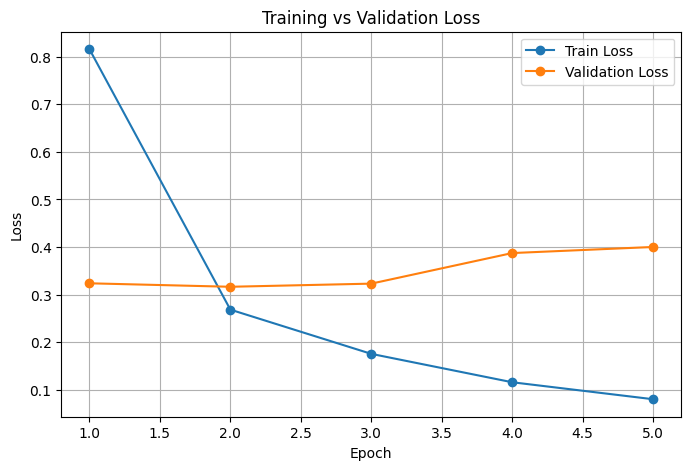

In [25]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, history["train_loss"], marker='o', label='Train Loss')
plt.plot(epochs, history["val_loss"], marker='o', label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


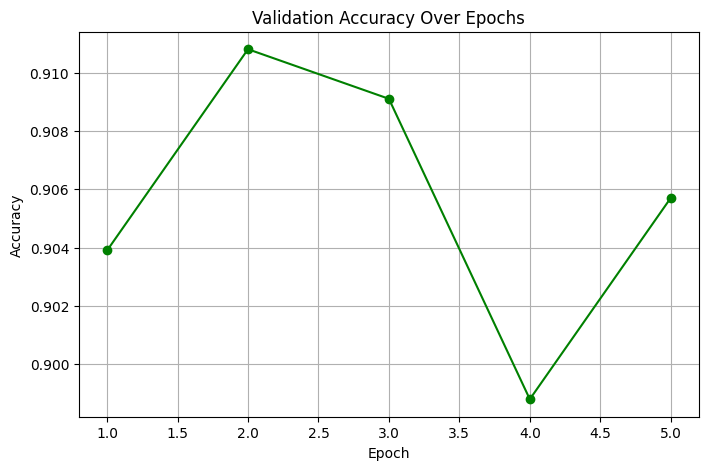

In [26]:
plt.figure(figsize=(8,5))
plt.plot(epochs, history["val_acc"], marker='o', color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
